# Exploratory data analysis

## Visualizing risk dataset

Some exploration of the output risk dataset being created in this repo.

In [ ]:
# saved for plotting side-by-side pots
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
for arr, ax in zip(arrs, axes):
    im = ax.imshow(arr, interpolation="none")
    ax.set_title(f"plot title")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.25, 0.02, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.get_yaxis().labelpad = 30
cbar.set_label('cbar label', size=14, rotation=0)

plt.suptitle("fig title", size=14)
plt.show()

## NCAR Data

Some exploration of the NCAR BCSD data.

#### How long does it take to load the data?

Current pipeline is reading in each dataset twice as it iterates over years. Hoe long does it take to just load all of the data for a particular year using `xarray.open_mfdataset`? Also how does this compare to the time taken to copy it to scratch space and then open it? Will use a simple `min()` operation to benchmark.

In [20]:
from pathlib import Path


met_dir = Path("/Data/Base_Data/Climate/AK_NCAR_12km/met")
tmp_fn = "{}_{}_BCSD_met_{}.nc4"
model = "CCSM4"
scenario = "rcp45"

fps = [met_dir.joinpath(model, scenario, tmp_fn.format(model, scenario, year)) for year in range(1950, 2010)]

Reading from Poseidon:

In [24]:
import xarray as xr


ds = xr.open_mfdataset(fps)

In [27]:
%time test = ds["tmin"].min(axis=0).compute()

/home/UA/kmredilla/miniconda3/envs/py39/lib/python3.9/site-packages/dask/array/reductions.py:586: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)


CPU times: user 38.7 s, sys: 5.95 s, total: 44.7 s
Wall time: 1min 48s


Wow that is not too bad. Going to try changing the read/compute strategy up a bit in the pipeline.

#### Equal historical values between future scenarios?

**Question - are the data for different scenarios of the same model have equal values for "historical" period before the emissions scenarios kick in?**

Iterate over the models and read in a sample time slice for the same time and compare.

In [10]:
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
import luts


def compare_scenarios(year):
    met_dir = Path("/workspace/Shared/Tech_Projects/NCAR_AK/met")
    tmp_fn = "{}_{}_BCSD_met_{}.nc4"

    date = f"{year}-01-01"

    results = []
    for model in luts.models:
        model_result = {"model": model}
        for varname in ["pcp", "tmin", "tmax"]:
            with xr.open_dataset(met_dir.joinpath(model, "rcp45", tmp_fn.format(model, "rcp45", year))) as ds45:
                rcp45_arr = ds45[varname].sel(time=date)

            with xr.open_dataset(met_dir.joinpath(model, "rcp85", tmp_fn.format(model, "rcp85", year))) as ds85:
                rcp85_arr = ds85[varname].sel(time=date)

            model_result[varname] = np.array_equal(rcp45_arr, rcp85_arr, equal_nan=True)
        results.append(model_result)
    results_df = pd.DataFrame(results)
    print(results_df)


Just poking around a few different years, there appear to be some inconsistencies. Looks like for 1950, `CCSM4` has the same data for `tmin`, but nothing else:

In [11]:
compare_scenarios(1950)

           model    pcp   tmin   tmax
0      ACCESS1-3  False  False  False
1        CanESM2  False  False  False
2          CCSM4  False   True  False
3  CSIRO-Mk3-6-0  False  False  False
4     GFDL-ESM2M  False  False  False
5     HadGEM2-ES  False  False  False
6         inmcm4  False  False  False
7         MIROC5  False  False  False
8     MPI-ESM-MR  False  False  False
9      MRI-CGCM3  False  False  False


Found another year where data match for `tmin`, for `HadGEM2-ES`, but nothing else:

In [12]:
compare_scenarios(1985)

           model    pcp   tmin   tmax
0      ACCESS1-3  False  False  False
1        CanESM2  False  False  False
2          CCSM4  False  False  False
3  CSIRO-Mk3-6-0  False  False  False
4     GFDL-ESM2M  False  False  False
5     HadGEM2-ES  False   True  False
6         inmcm4  False  False  False
7         MIROC5  False  False  False
8     MPI-ESM-MR  False  False  False
9      MRI-CGCM3  False  False  False


But it seems that the arrays don't match for any models for other years:

In [13]:
compare_scenarios(1990)

           model    pcp   tmin   tmax
0      ACCESS1-3  False  False  False
1        CanESM2  False  False  False
2          CCSM4  False  False  False
3  CSIRO-Mk3-6-0  False  False  False
4     GFDL-ESM2M  False  False  False
5     HadGEM2-ES  False  False  False
6         inmcm4  False  False  False
7         MIROC5  False  False  False
8     MPI-ESM-MR  False  False  False
9      MRI-CGCM3  False  False  False


In [14]:
compare_scenarios(1995)

           model    pcp   tmin   tmax
0      ACCESS1-3  False  False  False
1        CanESM2  False  False  False
2          CCSM4  False  False  False
3  CSIRO-Mk3-6-0  False  False  False
4     GFDL-ESM2M  False  False  False
5     HadGEM2-ES  False  False  False
6         inmcm4  False  False  False
7         MIROC5  False  False  False
8     MPI-ESM-MR  False  False  False
9      MRI-CGCM3  False  False  False


In [15]:
compare_scenarios(1967)

           model    pcp   tmin   tmax
0      ACCESS1-3  False  False  False
1        CanESM2  False  False  False
2          CCSM4  False  False  False
3  CSIRO-Mk3-6-0  False  False  False
4     GFDL-ESM2M  False  False  False
5     HadGEM2-ES  False  False  False
6         inmcm4  False  False  False
7         MIROC5  False  False  False
8     MPI-ESM-MR  False  False  False
9      MRI-CGCM3  False  False  False


### "degree days below the curve" testing

This section explores the idea of counting degree days under the curve, or something like it, for an estimate of cooling.

In [49]:
import numpy as np
import xarray as xr
from pathlib import Path
from itertools import product

In [26]:
met_dir = Path("/workspace/Shared/Tech_Projects/NCAR_AK/met")
tmp_fn = "{}_{}_BCSD_met_{}.nc4"

In [28]:
model = "ACCESS1-3"
scenario = "hist"

In [175]:
ds = xr.open_mfdataset([
    met_dir.joinpath(model, scenario, tmp_fn.format(model, scenario, year))
    for year in range(1980, 2010)
])

In [196]:
test_fall_arr = []
for year in range(1980, 2010):
    winter_tmin = ds["tmin"].sel(
        time=slice(f"{year - 1}-07-01", f"{year}-06-30")
    ).values
    test_fall_arr.append(np.flipud(np.apply_along_axis(fall_cooling, 0, winter_tmin)))
test_fall_arr = np.array(test_fall_arr)

In [186]:
nodata_mask = np.broadcast_to(np.flipud(np.isnan(winter_tmin[0])), test_fall_arr.shape)

Plot the mean degree days under the curve for ACCESS1-3 historical, 1980-2010

In [213]:
mean_arr = test_fall_arr.mean(axis=0)
mean_arr[np.flipud(np.isnan(winter_tmin[0]))] = np.nan
mean_arr[mean_arr > 70] = np.nan

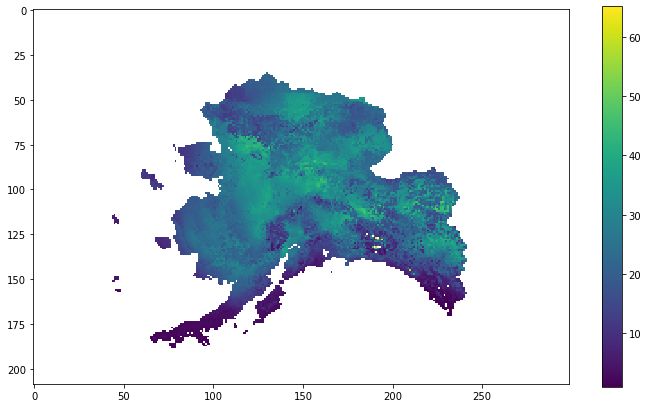

In [216]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 1, figsize=(12, 7))

plt.imshow(mean_arr, interpolation="none")
plt.colorbar()

In [ ]:
# pulling som data from Nancy's spreadsheet

